# 05 - Downstream Integration

In [1]:
from libraries import *
from parameters import *
from sklearn import linear_model

In [2]:
%load_ext rpy2.ipython

In [3]:
os.getcwd()
os.chdir(projectDir)

In [4]:
adata = sc.read(par_save_filename_1)

## Normalization and log transform

In [5]:
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=par_preprocessing_target_sum)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell
    finished (0:00:03)


In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=par_downstream_n_top_genes)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [7]:
sc.pp.scale(adata, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [8]:
n_pcs = min(min(adata.n_obs, adata.n_vars)-1, par_downstream_n_pcs)
n_pcs

50

## PCA, UMAP embedding and leiden clustering

In [9]:
sc.pp.pca(adata, n_comps=n_pcs, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:38)


In [10]:
sc.pp.neighbors(adata, n_neighbors=par_downstream_n_neighbors, metric=par_downstream_neighbor_metric)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:25)


In [11]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:09:39)


In [12]:
sc.tl.leiden(adata, resolution=par_leiden_clustering_resolution)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:15:48)


In [13]:
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:01)
    eigenvalues of transition matrix
    [1.         0.99861294 0.9971593  0.99403596 0.98671097 0.9859159
     0.9817559  0.9791275  0.9759955  0.97502106 0.9728861  0.9716241
     0.96987206 0.968932   0.9678033 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:21)


In [14]:
umap_point_size = np.maximum(120000/adata.n_obs, 2)

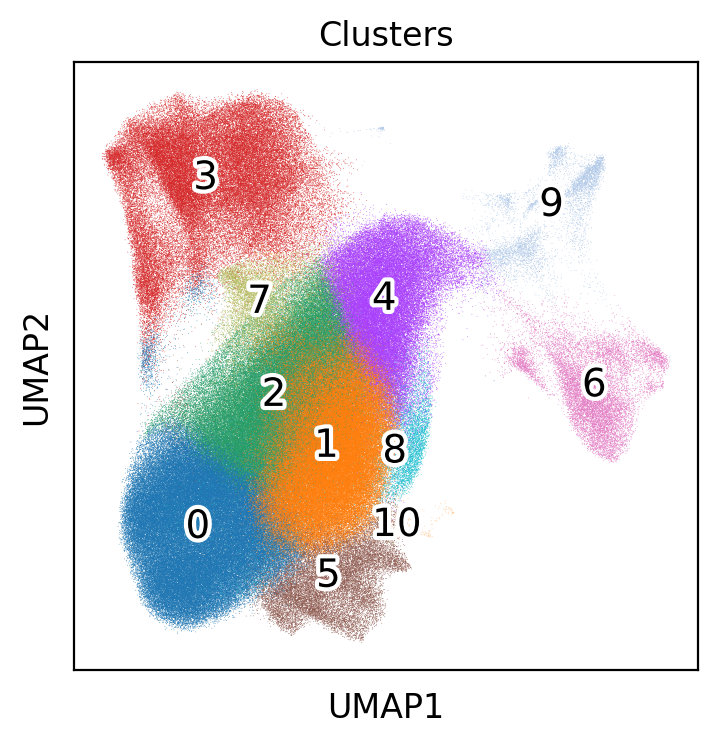

In [15]:
f, ax = plt.subplots(figsize=(4, 4))
sc.pl.umap(adata, color='leiden', 
           legend_loc='on data', 
           legend_fontoutline=3, 
           legend_fontsize=14, 
           legend_fontweight='normal', 
           title='Clusters', 
           ax=ax, 
           show=False, 
           size=0.3);

In [16]:
sc.tl.dendrogram(adata, groupby='leiden')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


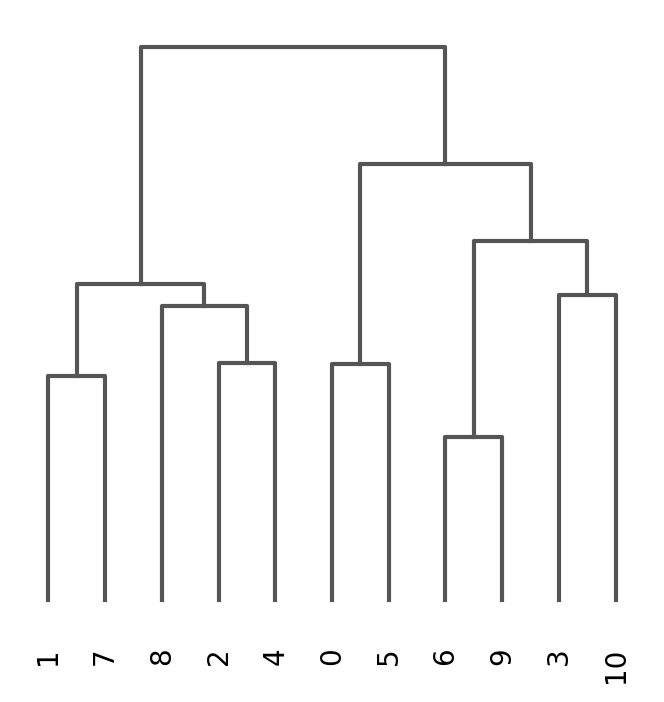

<AxesSubplot:>

In [17]:
sc.pl.dendrogram(adata, groupby='leiden')

## Identify and plot cluster marker genes

In [18]:
sc.tl.rank_genes_groups(adata, groupby="leiden", n_genes=2000, method="t-test_overestim_var")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:04)


In [19]:
markerGenes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
markerGenes = markerGenes.iloc[0:10,:]
markerGenes = np.unique(markerGenes.values.flatten())

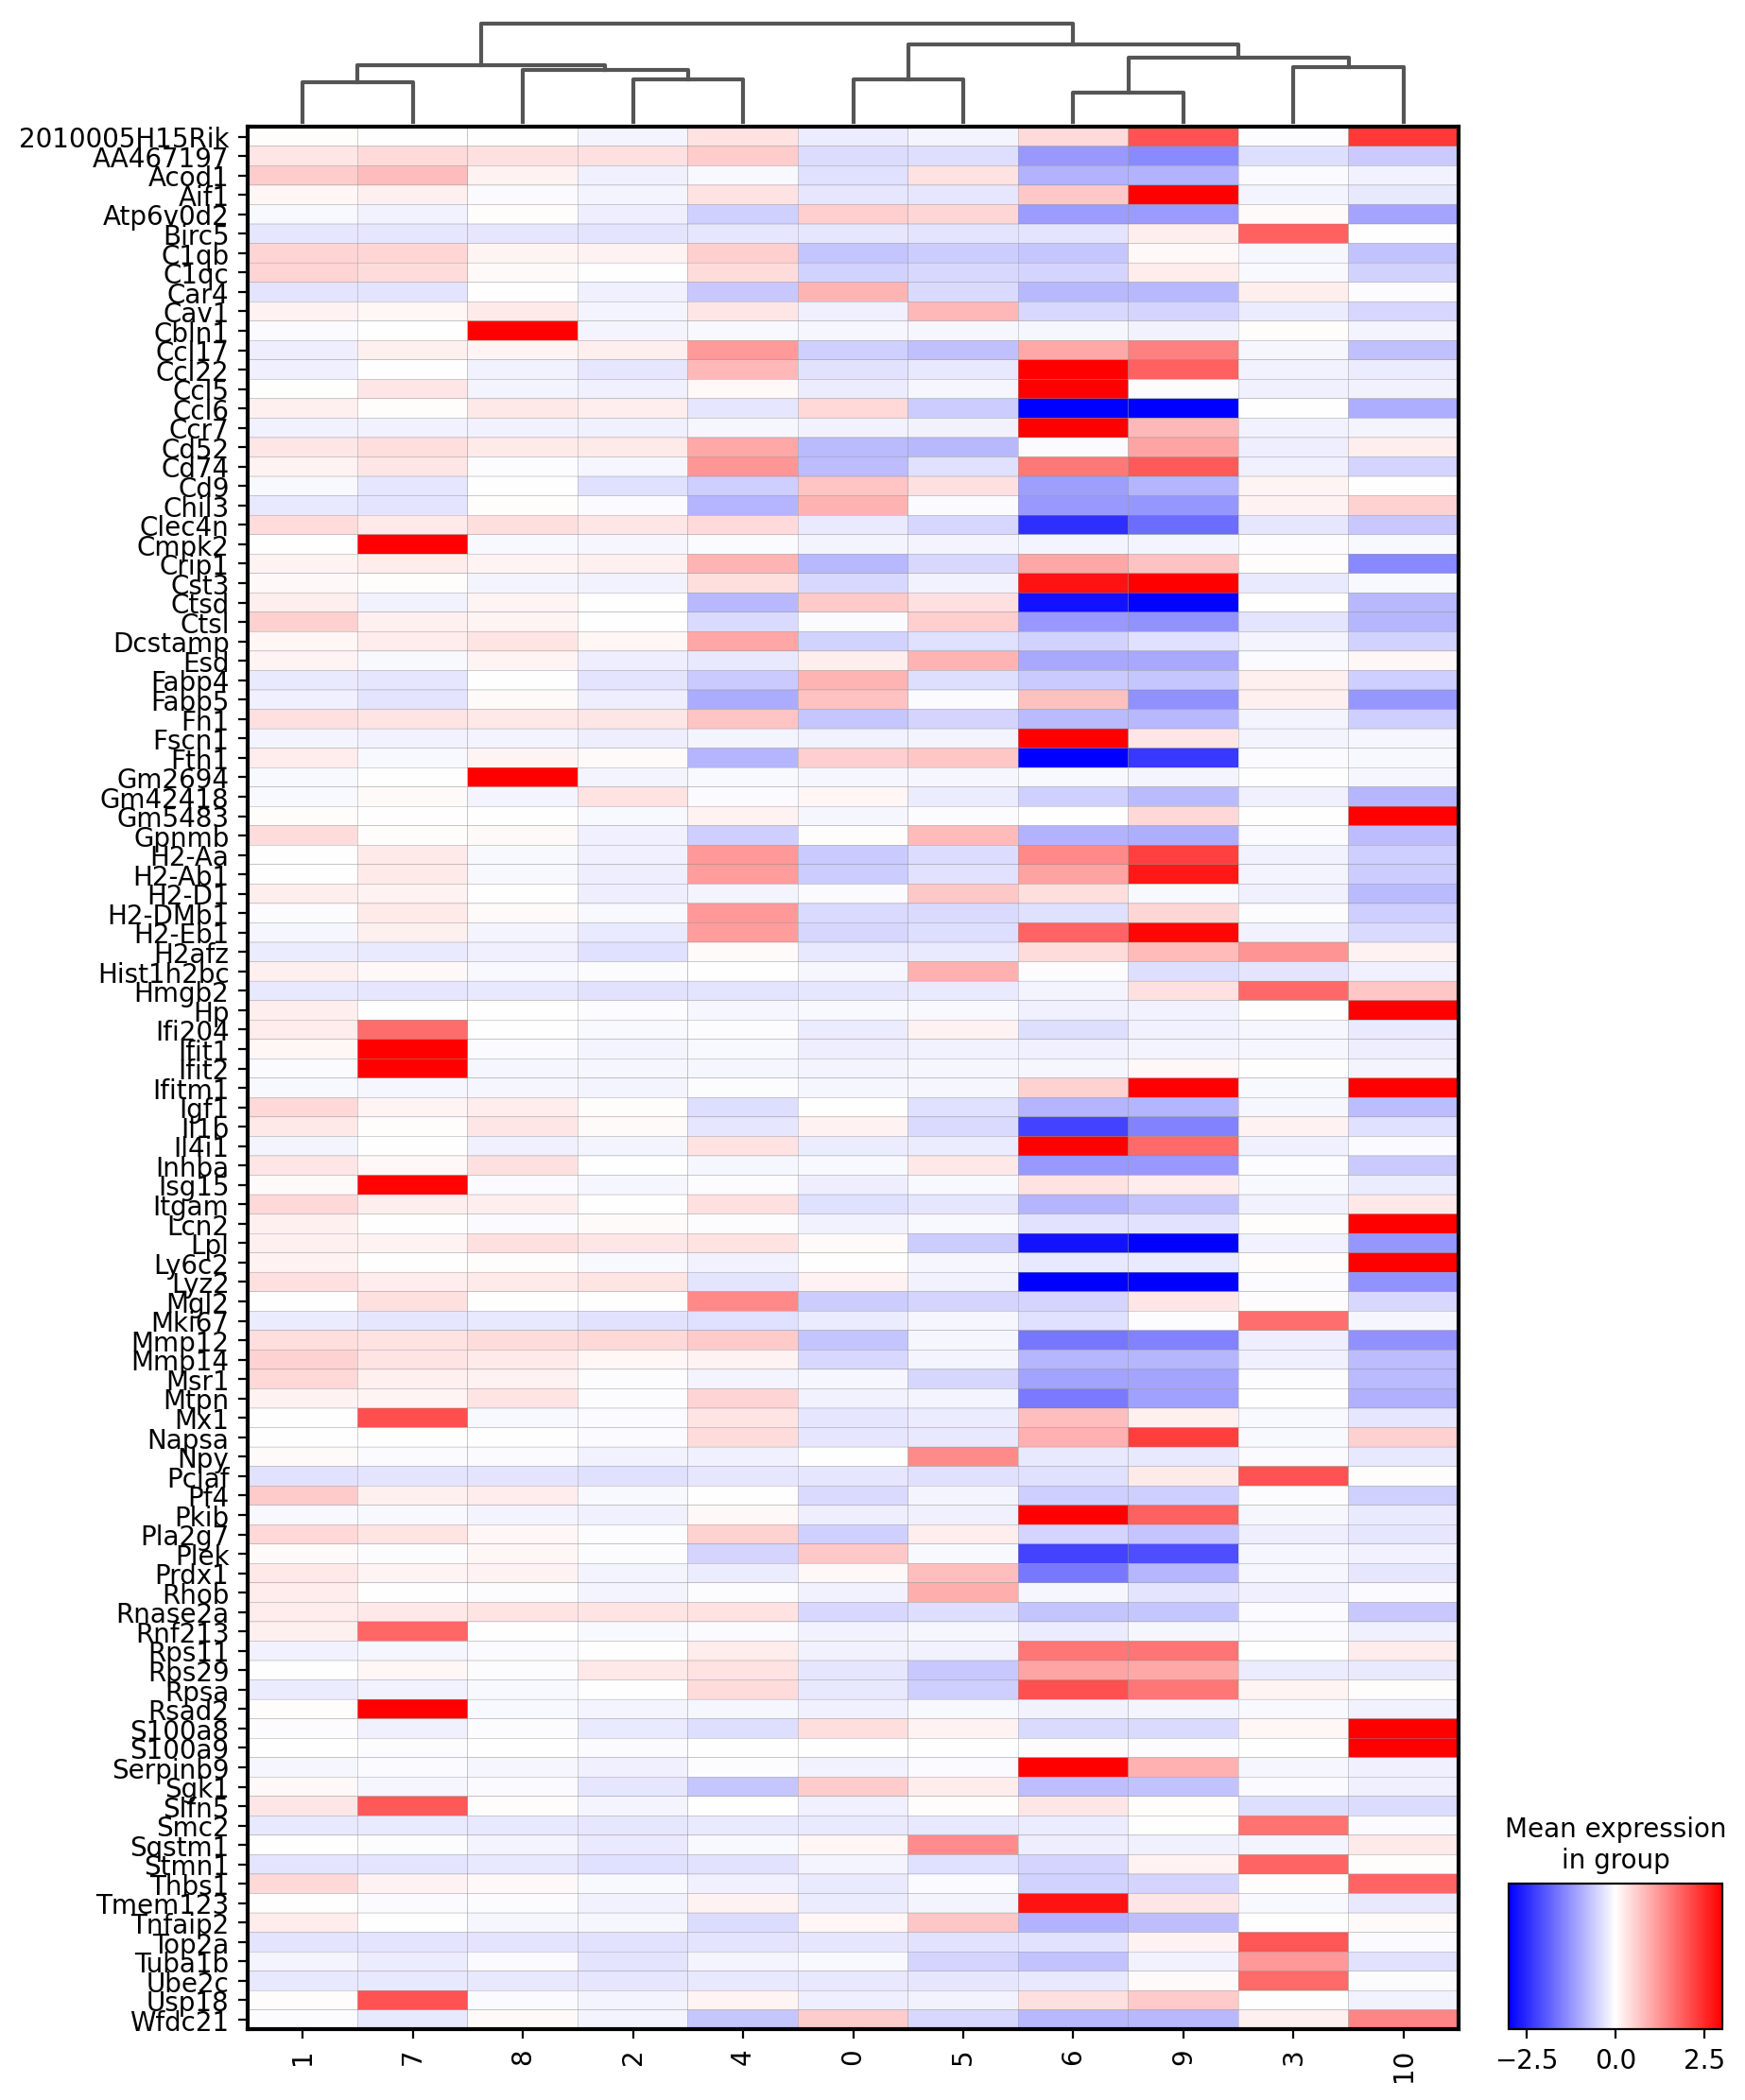

In [20]:
sc.pl.matrixplot(adata, markerGenes, groupby='leiden', dendrogram=True,
                      use_raw=False, vmin=-3, vmax=3,cmap='bwr',  swap_axes=True, figsize=(10,14))

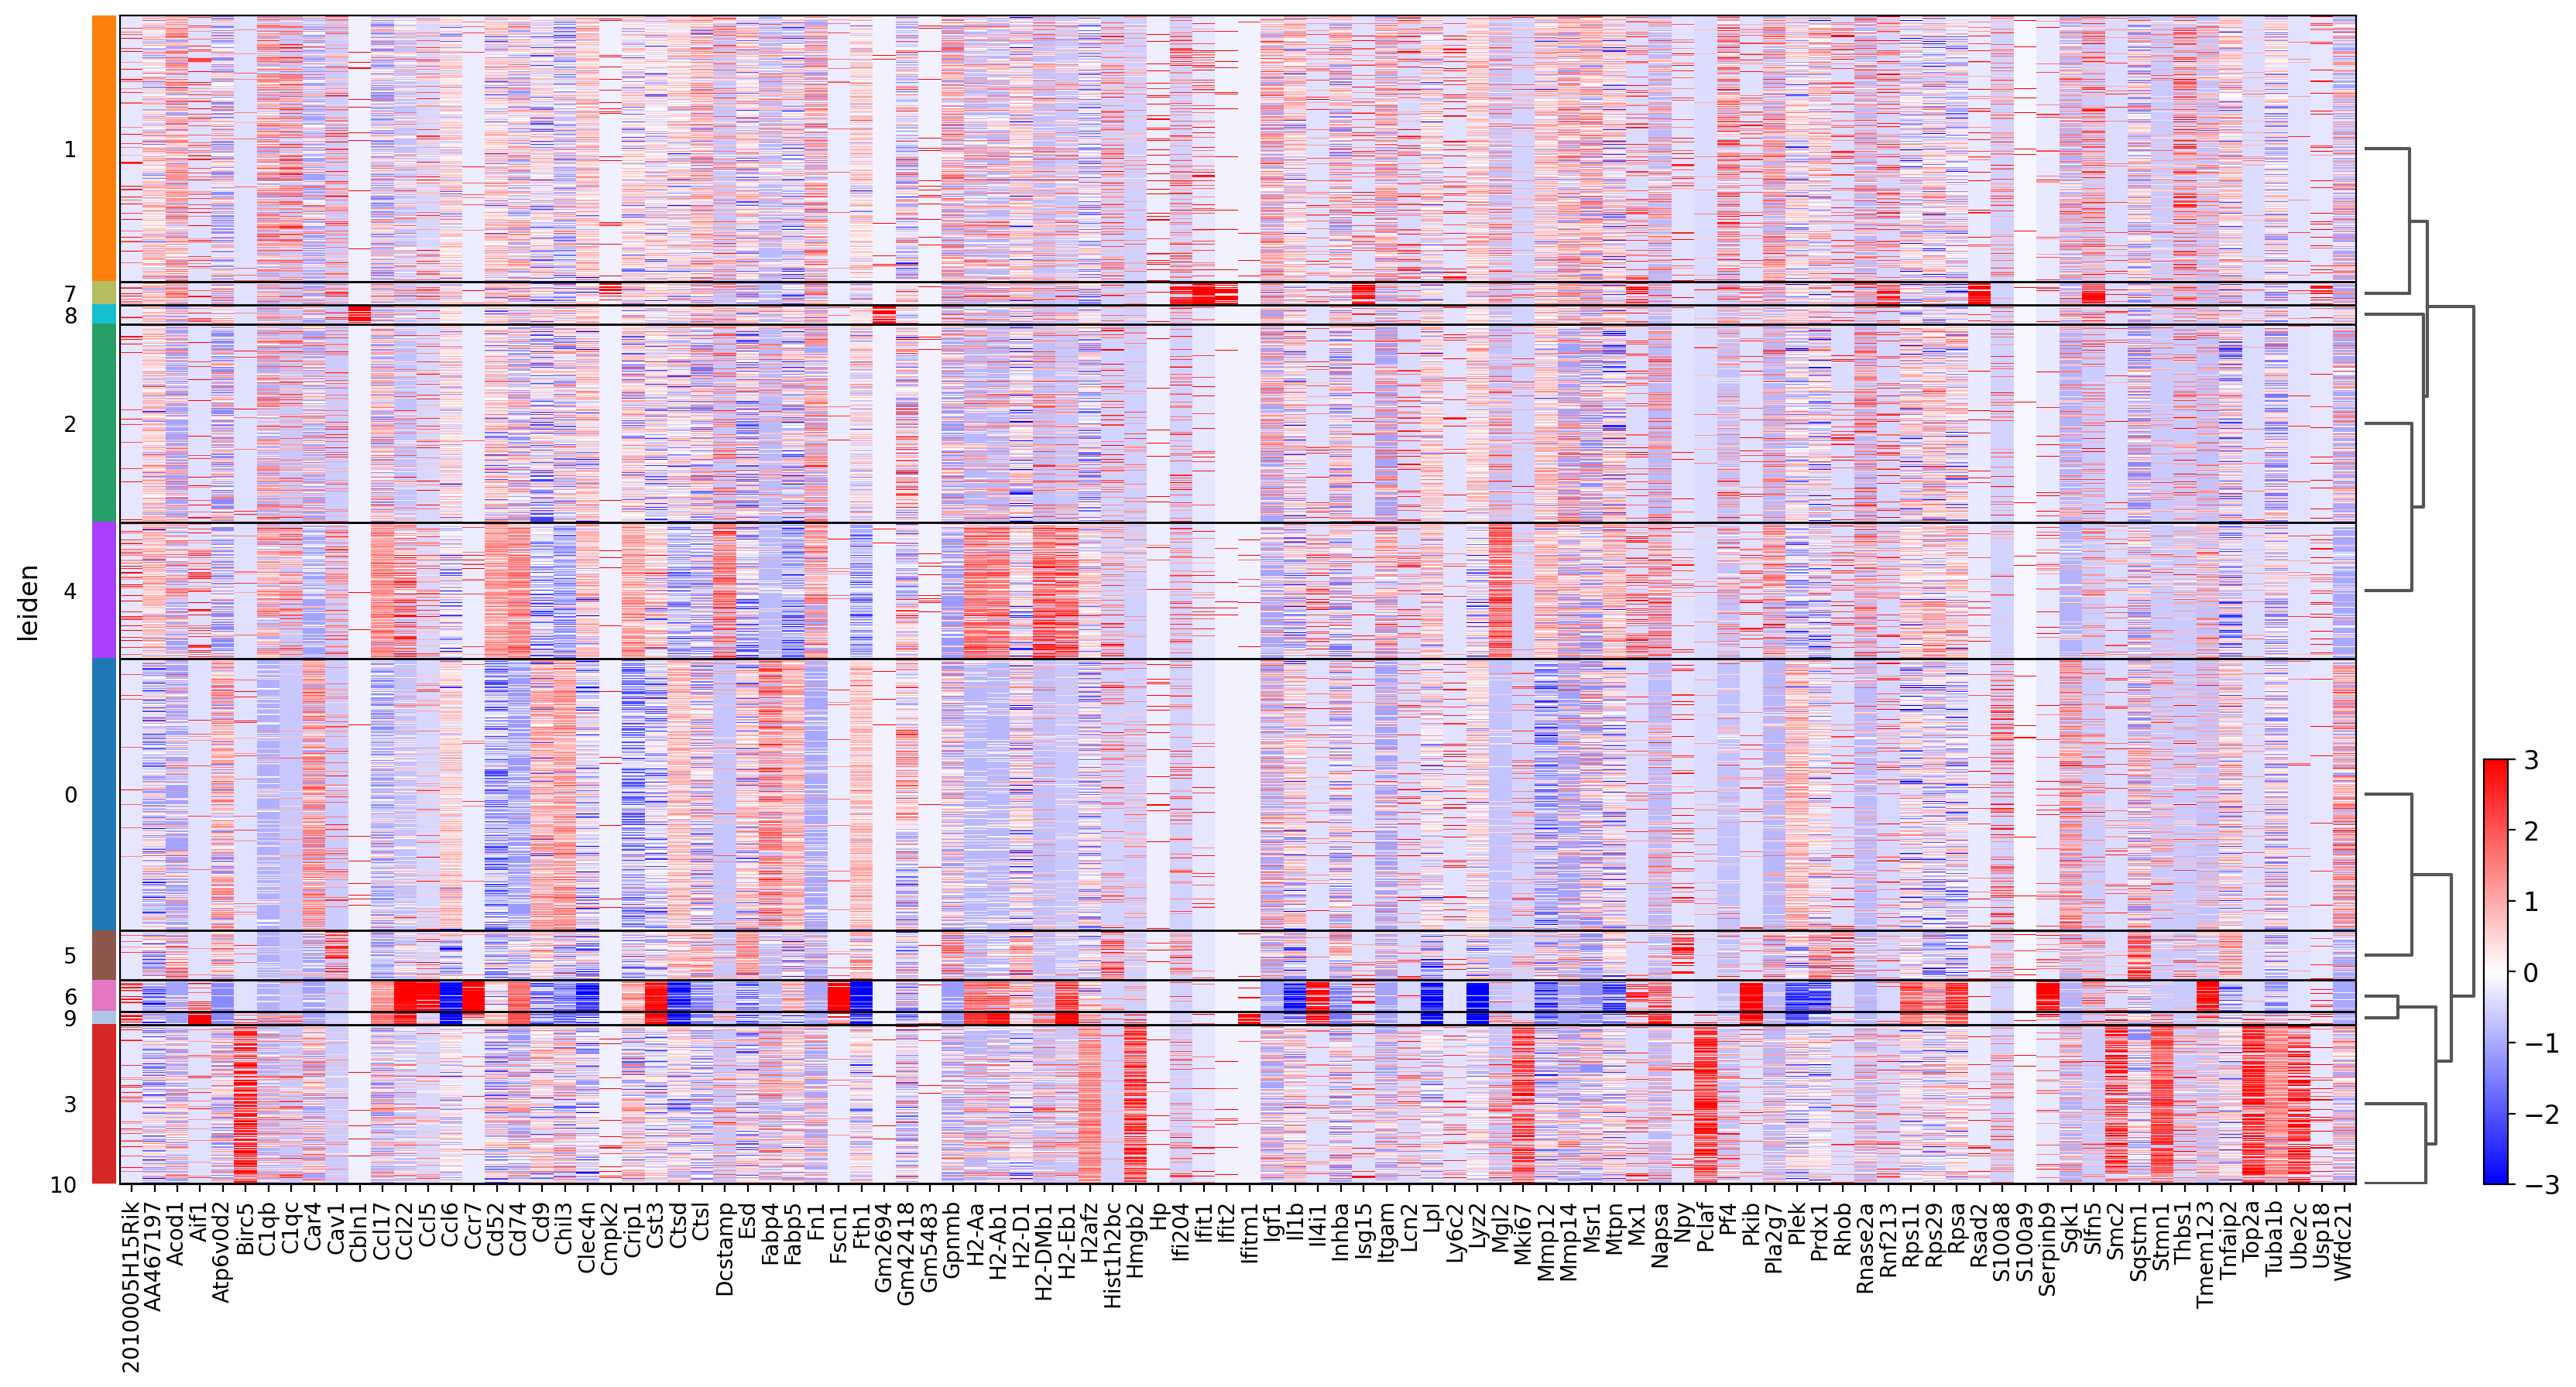

In [21]:
sc.pl.heatmap(adata, markerGenes, 
              groupby='leiden', 
              figsize=(20, 10),
              use_raw=False,
              vmin=-3, 
              vmax=3,
              cmap='bwr', 
              show_gene_labels=True, 
              dendrogram=True, 
              swap_axes=False)

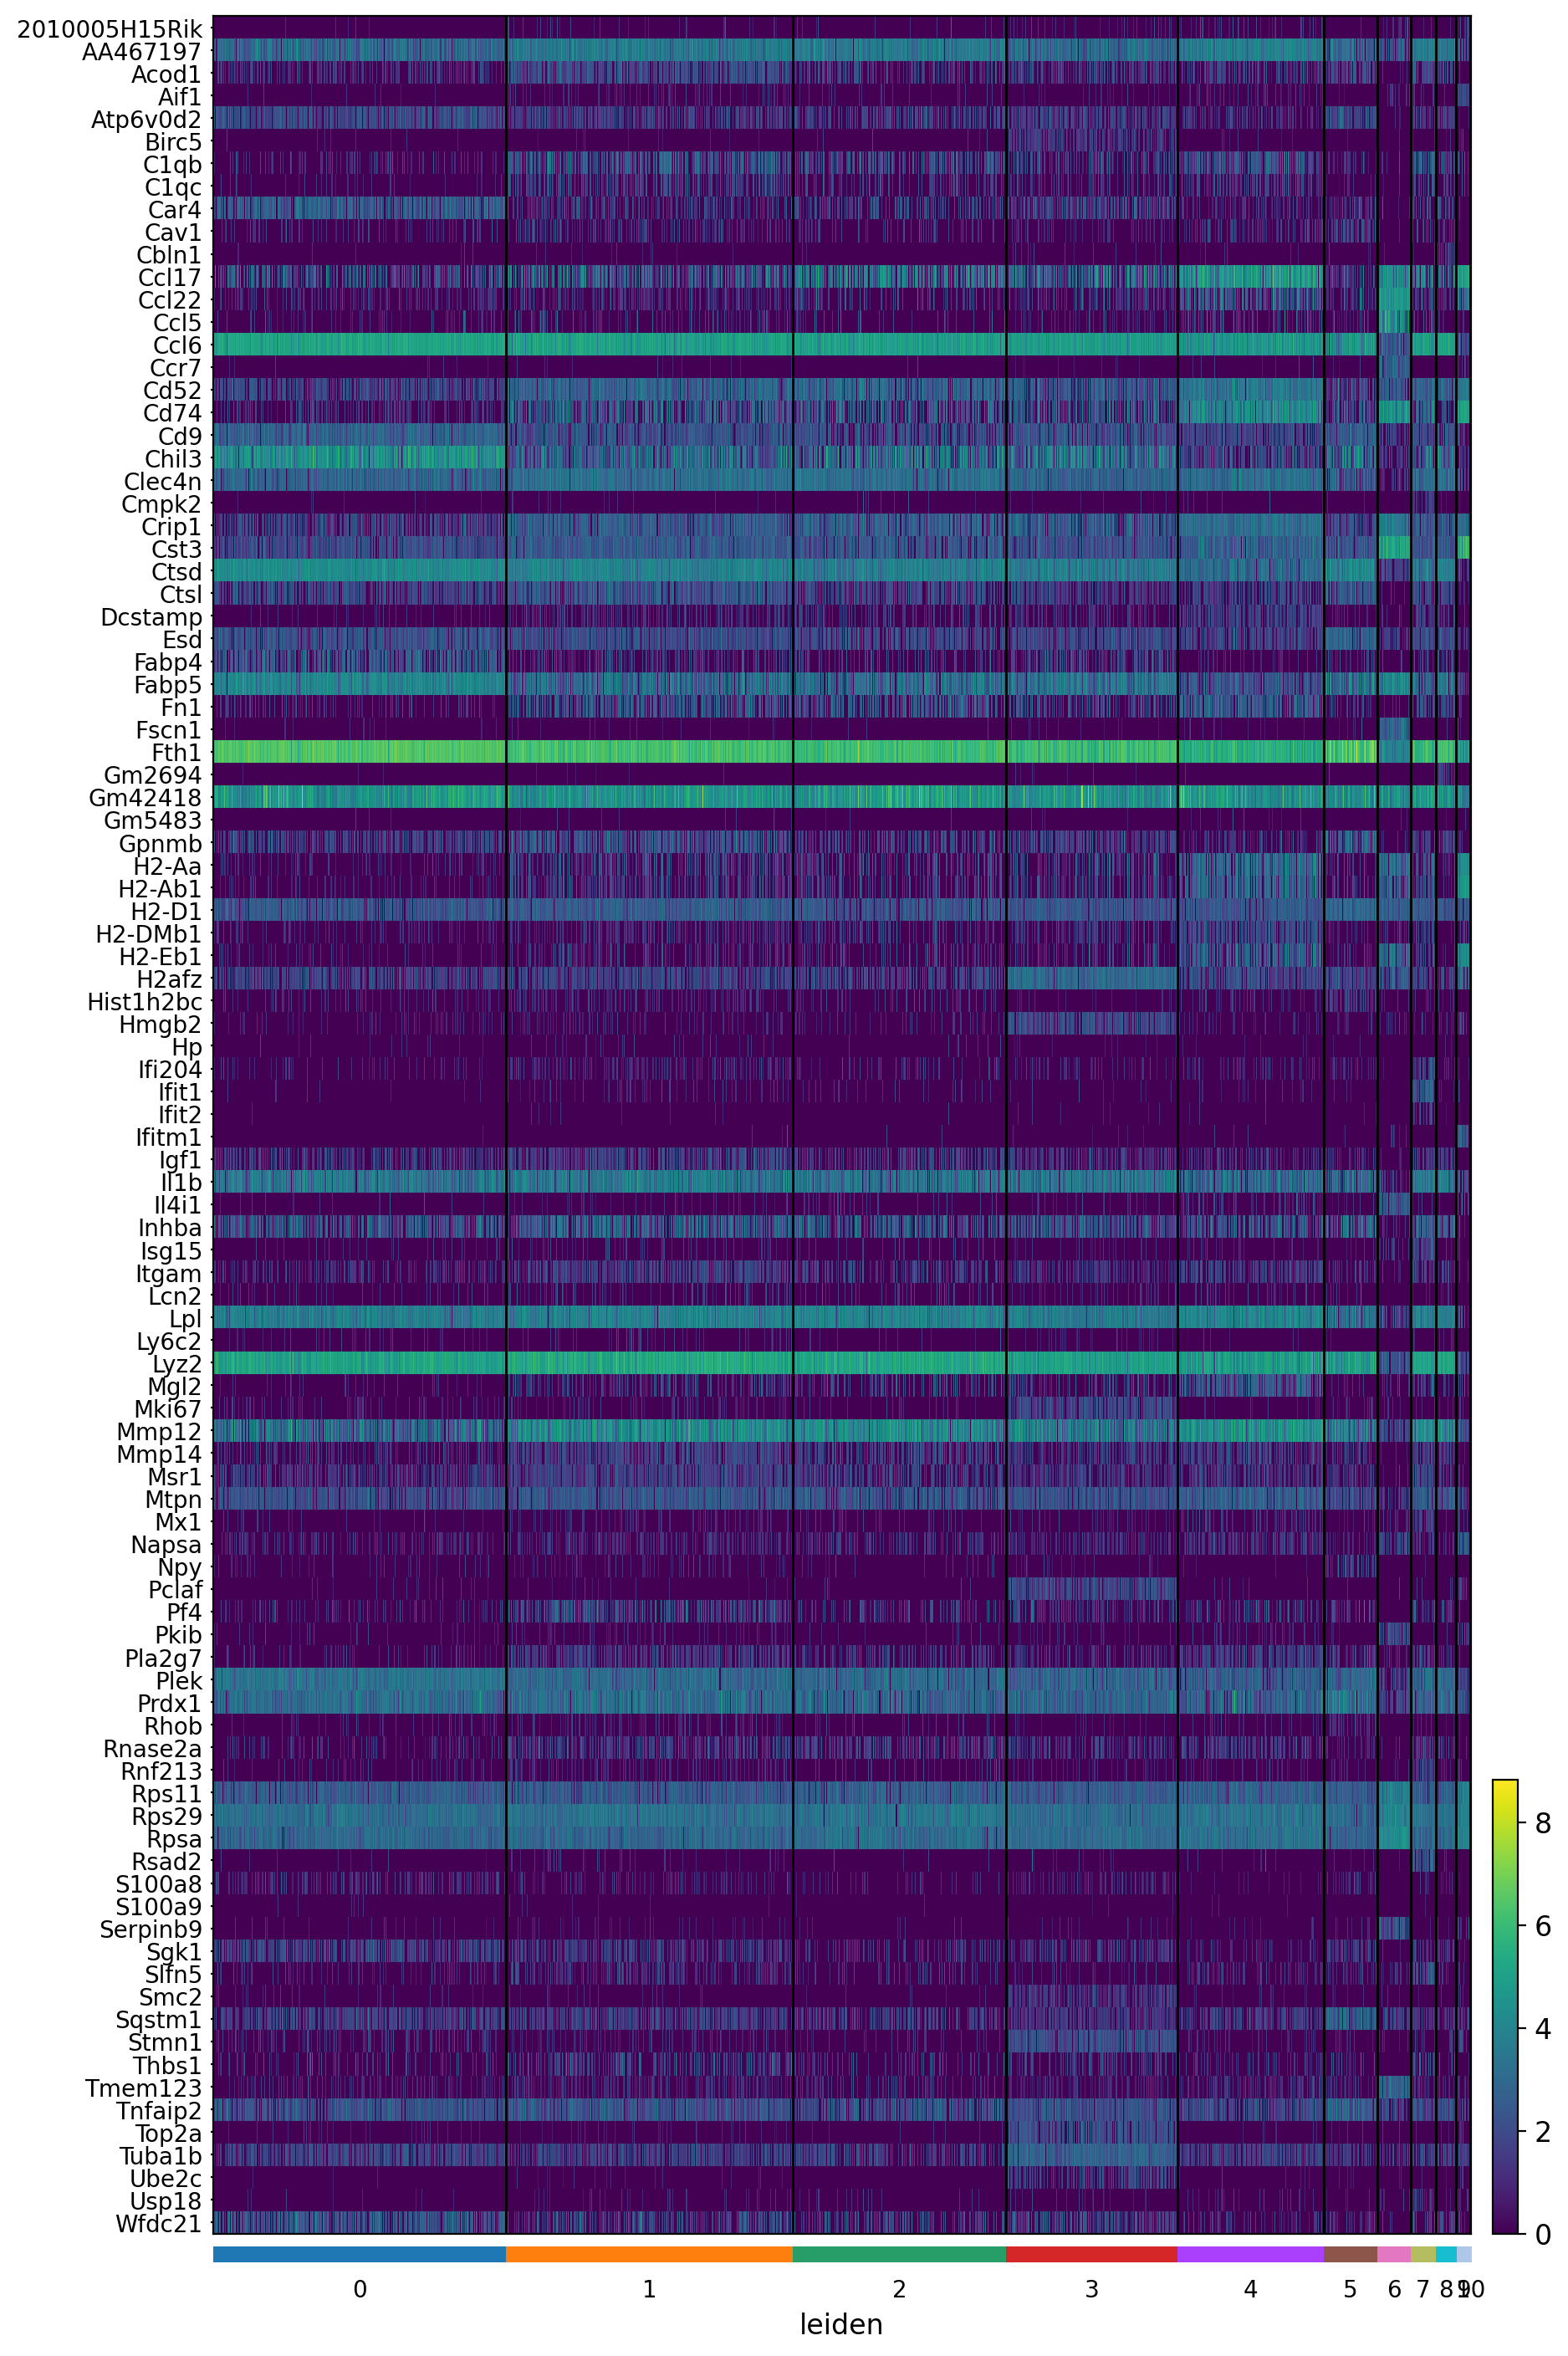

In [22]:
sc.pl.heatmap(adata,markerGenes, 
              groupby='leiden', 
              show_gene_labels=True, 
              swap_axes=True)

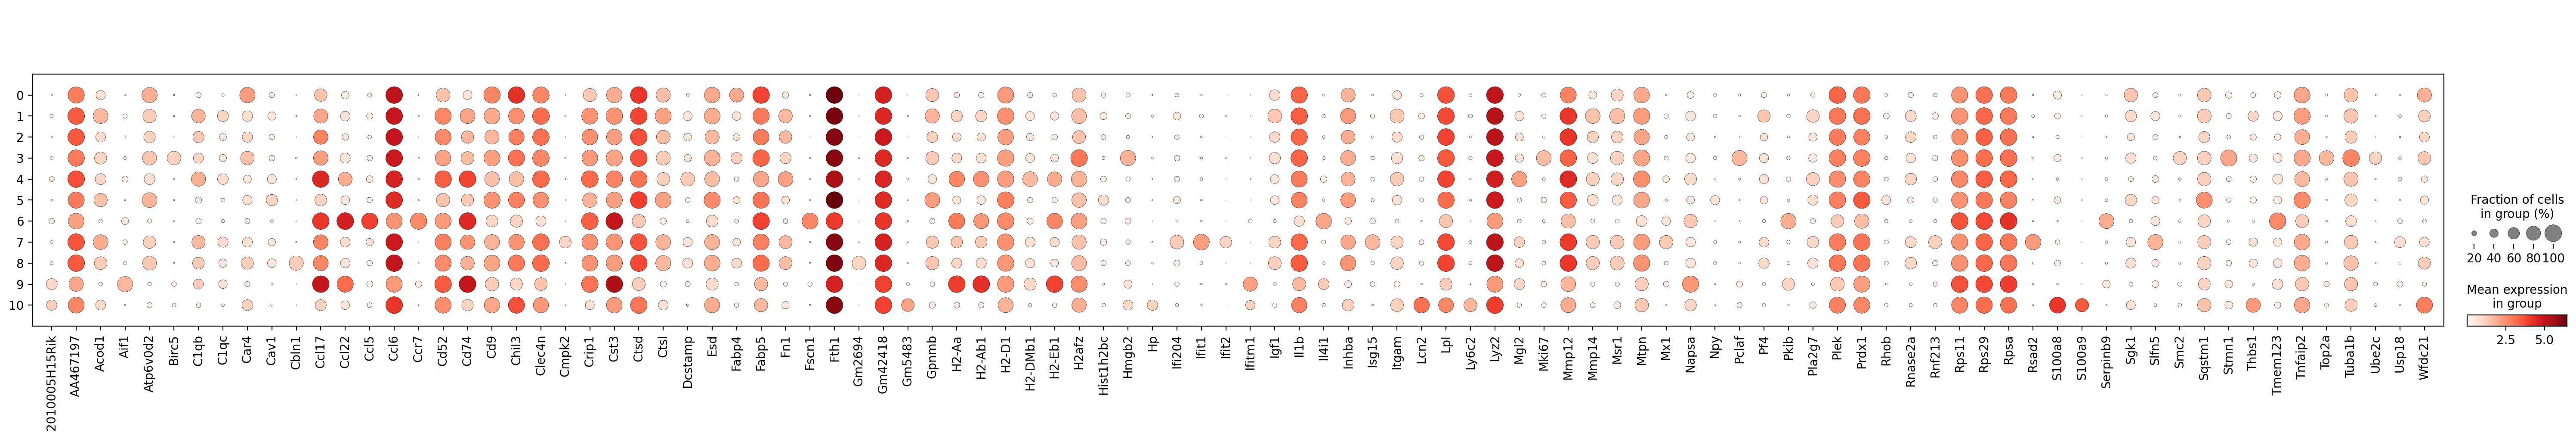

In [23]:
sc.pl.dotplot(adata, markerGenes, groupby='leiden')

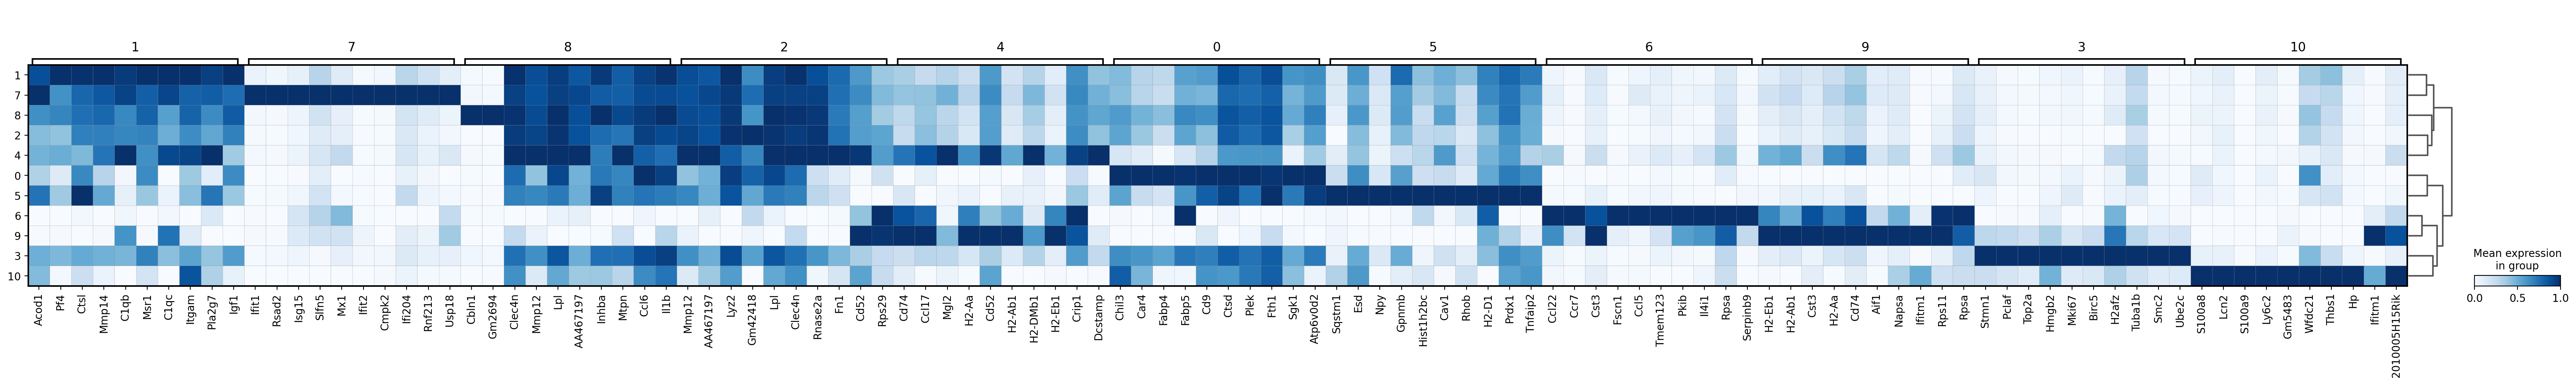

In [24]:
sc.pl.rank_genes_groups_matrixplot(adata, 
                                   n_genes=10, 
                                   standard_scale='var', 
                                   cmap='Blues')

## Scoring cell cycle signatures

In [25]:
gene_list_url = 'https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt'

cell_cycle_genes = [str(x.strip(), 'utf-8').capitalize() for x in urlopen(gene_list_url)] # capitalize = shame


s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'


/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    643 total control genes are used. (0:00:12)
computing score 'G2M_score'


/home/eraslab1/miniconda3/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    683 total control genes are used. (0:00:12)
-->     'phase', cell cycle phase (adata.obs)


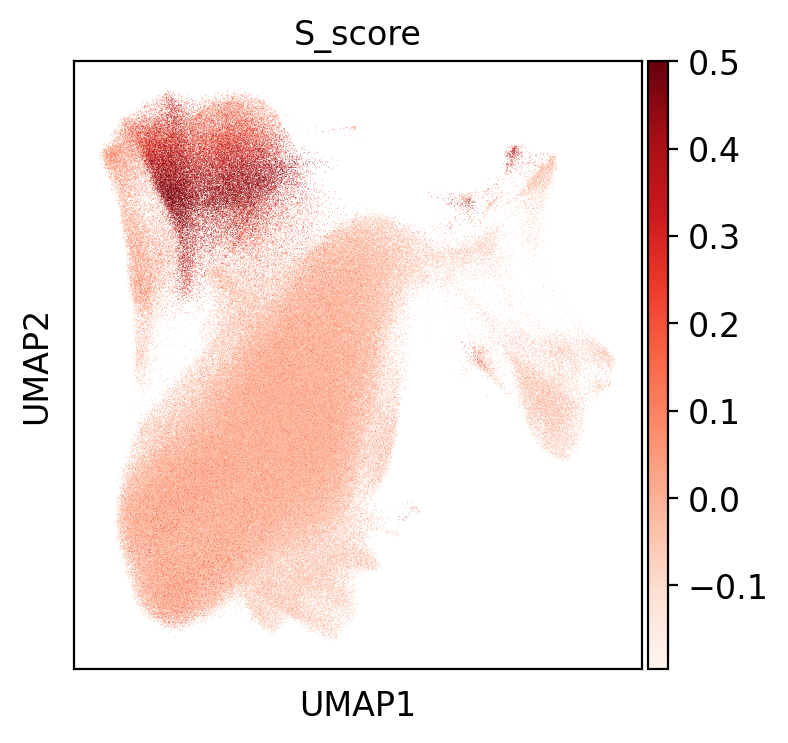

In [26]:
sc.pl.umap(adata, color='S_score', vmax=0.5, cmap='Reds')

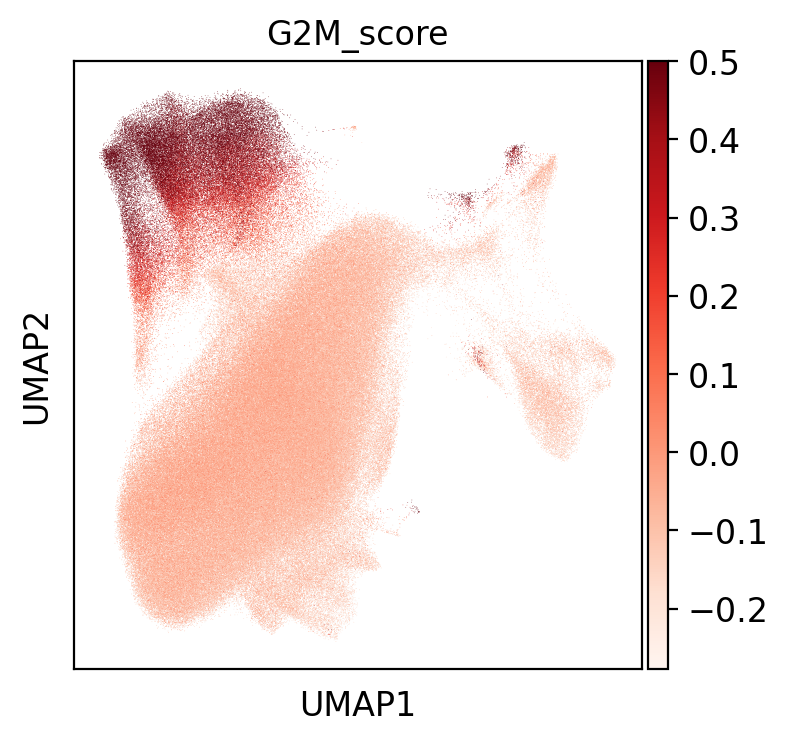

In [27]:
sc.pl.umap(adata, color='G2M_score', vmax=0.5, cmap='Reds')

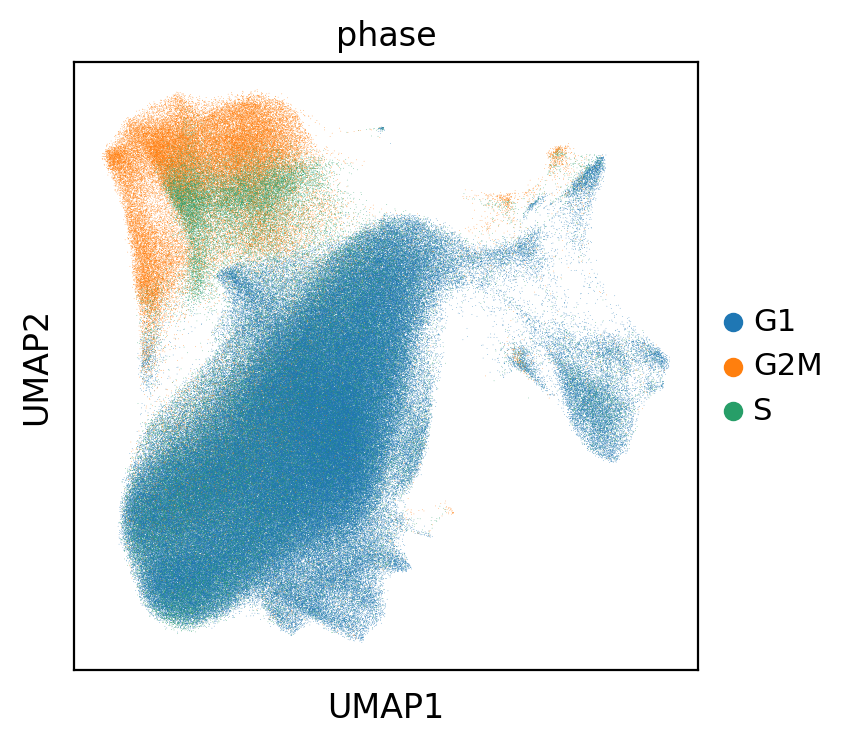

In [28]:
sc.pl.umap(adata, color='phase', vmax=0.5, cmap='Reds')

## Percent mito UMI

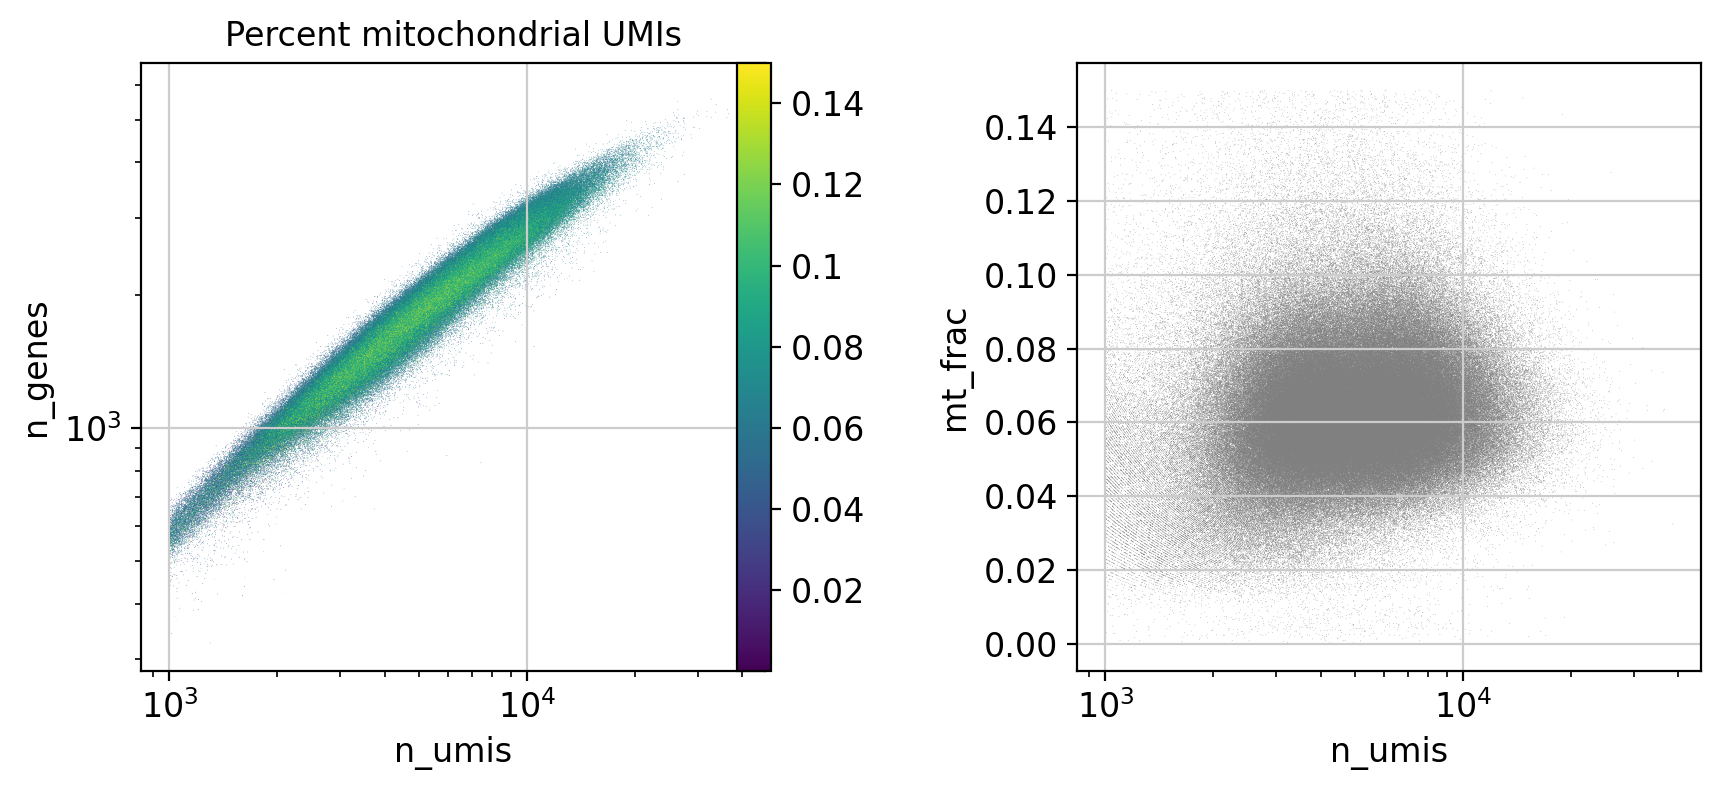

In [42]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
sc.pl.scatter(adata,
              x='n_umis',
              y='n_genes',
              color='mt_frac',
              ax=ax[0],
              show=False,
              right_margin=1.5,
              title='Percent mitochondrial UMIs')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

sc.pl.scatter(adata, x='n_umis', y='mt_frac', ax=ax[1], show=False)
ax[1].set_xscale('log')
plt.subplots_adjust(wspace=0.5)

# sc.pl.violin(adata, keys='log10_n_umis', groupby='sample_name', rotation=90, ax=ax[2], show=False)
# sc.pl.violin(adata, keys='log10_n_umis', groupby='sample_name', rotation=90, ax=ax[3], show=False)

In [30]:
adata.write(par_save_filename_1)

## Save the single and multiple KO cells

In [43]:
fBarMat = adata.obs[adata.uns['feature_barcode_names']]
fBarMat[fBarMat>0] = 1

/tmp/ipykernel_43955/3209677806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat>0] = 1
/tmp/ipykernel_43955/3209677806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fBarMat[fBarMat>0] = 1


In [44]:
adata.obs = adata.obs.assign(KONo = fBarMat.sum(axis=1).to_numpy()) 
adata.obs = adata.obs.assign(KOType = "SingleKO")
adata.obs.loc[adata.obs.KONo > 1,'KOType'] = "MultipleKO"
adata.obs["KOType"].value_counts()

SingleKO      341664
MultipleKO    177871
Name: KOType, dtype: int64

In [45]:
for elem in fBarMat.columns.to_list():
     adata.obs.loc[adata.obs[elem] > 0,elem] = 1

In [46]:
df = adata.obs[["n_genes", "mt_frac", "leiden" ]]
dummies = pd.get_dummies(df.leiden)
df = df.join(dummies)
df.drop(["leiden"], axis=1,inplace = True) 

rnaMat = adata.X
rnaMat = pd.DataFrame(rnaMat)
rnaMat.columns = adata.var_names
rnaMat.index = adata.obs_names

# Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr = linear_model.LinearRegression(fit_intercept = False) 
regr.fit(df, rnaMat)
predicted = regr.predict(df)

residuals = rnaMat-predicted

adata.layers["ClusterResiduals"] = residuals


In [47]:
adataSingle = adata[adata.obs.KOType == "SingleKO", :]
adataMultiple = adata[adata.obs.KOType == "MultipleKO", :]

In [48]:
adataSingle.write(par_save_filename_5)

/home/eraslab1/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [49]:
adataMultiple.write(par_save_filename_6)